# AI Project — Toxic Comment Classification (Multi-Label)

**Subject:** Intro to AI — Assessment Task 2 (Group Project)  
**Notebook:** all-in-one (EDA → Baselines → Main model → Evaluation)

---

## Problem
Given a short **comment** (`comment_text`), predict **six independent labels**:

`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`

This is **multi-label classification** (each label is a separate yes/no decision). Neural models use **6 logits → sigmoid** with **binary cross-entropy (BCEWithLogits)**.

> **Content notice:** The dataset contains abusive language. We **mask examples in outputs** for readability and wellbeing. Raw text is kept for model training only.

---

## Dataset
- Source: Jigsaw toxic comments (Kaggle).  
- Columns: `comment_text` + the six 0/1 label columns.  
- Cleaning is **minimal** (normalize, strip HTML, replace URLs, lowercase). **Do not remove profanity** — it’s the signal.

---

## Models we compare
1. **SVC baseline:** `TF-IDF (1–2 n-grams) + LinearSVC (One-Vs-Rest)`  
   - Strong, fast n-gram baseline.  
   - We use **decision_function scores** for PR-AUC (no probability calibration).

2. **BiLSTM:** `Embedding → BiLSTM → Pooling → Dense(6, sigmoid)`  
   - Sequence model that captures word order.

3. **DistilBERT (primary):** pre-trained Transformer with a 6-logit head  
   - Best quality/compute balance; handles nuance and rare labels.

---

## Evaluation protocol (fair and reproducible)
- **Split:** `Train / Val / Test = 80/10/10`, fixed seed.  
- **No leakage:** Fit vectorizers/tokenizers on **train only**.  
- **Thresholds:** Tune **per-label thresholds on Validation** to maximise **F1** for each label (apply the chosen thresholds to Test).  
- **Scores for PR-AUC:**  
  - DistilBERT & BiLSTM: use **sigmoid(logits)**.  
  - SVC: use **decision_function margins** (valid ranking scores).

**Metrics reported (Validation for tuning, Test for final):**
- **Primary:** **Micro-F1**, **Macro-F1**  
- **Per-label:** F1 for each of the 6 labels  
- **Ranking quality:** **PR-AUC (Average Precision)** per label + **Mean PR-AUC**  
- **(Optional) Efficiency:** model size and inference time / 1k comments

**Figures saved & shown:**
- Label prevalence bar chart  
- PR curves for 2 hardest labels (e.g., `severe_toxic`, `threat`)  
- (Optional) small 2×2 confusion matrices per label  
- 6–8 **masked** error cards (text, true vs predicted)

---

## Modelling choices (key settings)
- **Multi-label wiring:** 6 logits → **sigmoid** (not softmax).  
- **Loss:** BCEWithLogits for neural models.  
- **Imbalance:** address via **per-label thresholds** (and, for neural models, optional class weights).  
- **Max sequence length (start):** 128 tokens; revisit if many inputs are longer.  
- **Seed:** 42 across all steps for reproducibility.

---

## Ethics & practice
- Mask offensive text in human-readable outputs.  
- Keep data private and cite the source.  
- Discuss risks (bias, false positives/negatives) and mitigations (careful thresholds, human review on borderline cases).



In [ ]:
# Imports, config, and reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
np.random.seed(SEED)

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_colwidth", 200)

print("Seed set:", SEED)

Seed set: 42


## Load Dataset & Schema Check
**What this code does:**  
- Loads `train.csv` into a DataFrame.  
- Detects the **text column** and asserts the **six label columns** exist:  
  `toxic, severe_toxic, obscene, threat, insult, identity_hate`.  
- Fails early with a clear error if something is missing.

In [ ]:
# Load CSV
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Assignment 3/train.csv")

# Detect text column
CANDIDATE_TEXT = ["comment_text", "text", "comment", "body"]
TEXT_COL = next((c for c in CANDIDATE_TEXT if c in df.columns), None)
assert TEXT_COL is not None, f"Text column not found. Tried: {CANDIDATE_TEXT}"

# Expected labels
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
missing = [c for c in LABELS if c not in df.columns]
assert not missing, f"Missing label columns: {missing}"

print(f"Text column: {TEXT_COL}")
print(f"Label columns: {LABELS}")
print("Rows:", len(df))

Text column: comment_text
Label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Rows: 159571


## Light Cleaning (keep signal, remove formatting noise)
**What this code does:**  
- **Keeps** profanity (it’s the signal).  
- Lowercases text, removes simple HTML tags, replaces URLs with `<URL>`, collapses extra spaces.  
- Drops empty texts and exact duplicates.  
- Ensures labels are integers in {0,1}.  
- Prints before/after counts so the cleaning is transparent.

In [ ]:
before = len(df)

# Lowercase
df[TEXT_COL] = df[TEXT_COL].astype(str).str.lower()

# Replace URLs with placeholder
df[TEXT_COL] = df[TEXT_COL].str.replace(r"http[s]?://\S+|www\.\S+", " <URL> ", regex=True)

# Remove simple HTML tags
df[TEXT_COL] = df[TEXT_COL].str.replace(r"<[^>]+>", " ", regex=True)

# Collapse whitespace
df[TEXT_COL] = df[TEXT_COL].str.replace(r"\s+", " ", regex=True).str.strip()

# Ensure labels are 0/1 integers
for c in LABELS:
    df[c] = df[c].fillna(0).astype(int).clip(0, 1)

# Drop empty and exact duplicate texts
df = df[df[TEXT_COL].str.len() > 0]
after_empty = len(df)
df = df.drop_duplicates(subset=[TEXT_COL], keep="first")
after_dupe = len(df)

print("=== Cleaning summary ===")
print(f"Rows: {before:,} → after empty: {after_empty:,} → after de-dup: {after_dupe:,}")

=== Cleaning summary ===
Rows: 159,571 → after empty: 159,563 → after de-dup: 159,288


## Quick (masked) preview for humans
**What this code does:**  
- Shows a few example rows with **masked** offensive words (training still uses raw).  
- Confirms label dtypes are int.

In [ ]:
# Very small lexicon just for display masking (kept generic)
mask_terms = ["fuck","shit","bitch","asshole","bastard","cunt"]
pattern = r"\b(" + "|".join(mask_terms) + r")\b"

preview = df[[TEXT_COL] + LABELS].head(5).copy()
preview[TEXT_COL + "_masked"] = preview[TEXT_COL].str.replace(pattern, "***", regex=True, case=False)

print(preview[[TEXT_COL + "_masked"] + LABELS].to_string(index=False))
print("\nLabel dtypes:", {c: str(df[c].dtype) for c in LABELS})

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        comment_text_masked  toxic  severe_toxic  obscene  threat  insult  identity_hate
                                                                                                                                                                                                                                                                                                                               

## Missing values check
**What this code does:**  
- Counts missing values in the text and label columns, so we know the dataset is safe to use.

In [ ]:
na_counts = df[[TEXT_COL] + LABELS].isna().sum().sort_values(ascending=False)
print(na_counts.to_string())

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0


## Text length statistics (helps choose max sequence length later)
**What this code does:**  
- Computes character and word lengths, prints mean/median/p90/max.  
- Plots a histogram of character lengths.

char_len → mean: 387.6 medbian: 201 p90: 877 max: 5000
word_len → mean: 67.2


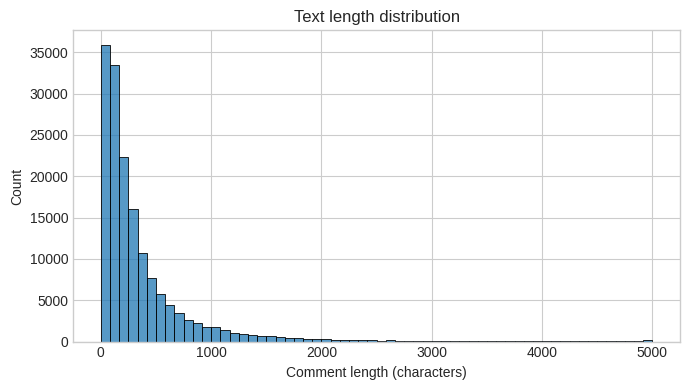

In [ ]:
df["char_len"] = df[TEXT_COL].str.len()
df["word_len"] = df[TEXT_COL].str.split().map(len)

print("char_len → mean:", round(df["char_len"].mean(),1),
      "medbian:", int(df["char_len"].median()),
      "p90:", int(df["char_len"].quantile(0.9)),
      "max:", int(df["char_len"].max()))
print("word_len → mean:", round(df["word_len"].mean(),1))

plt.figure(figsize=(7,4))
sns.histplot(df["char_len"], bins=60, kde=False)
plt.xlabel("Comment length (characters)")
plt.ylabel("Count")
plt.title("Text length distribution")
plt.tight_layout()
plt.show()

## Label prevalence (class imbalance)
**What this code does:**  
- Shows **count** and **rate** of each label.  
- Plots a bar chart.  
**Why:** Imbalance motivates using F1/PR-AUC instead of accuracy, and later **per-label thresholds**.

Label prevalence (count | rate):
toxic           15246 | 0.0957
severe_toxic     1590 | 0.0100
obscene          8420 | 0.0529
threat            474 | 0.0030
insult           7850 | 0.0493
identity_hate    1397 | 0.0088


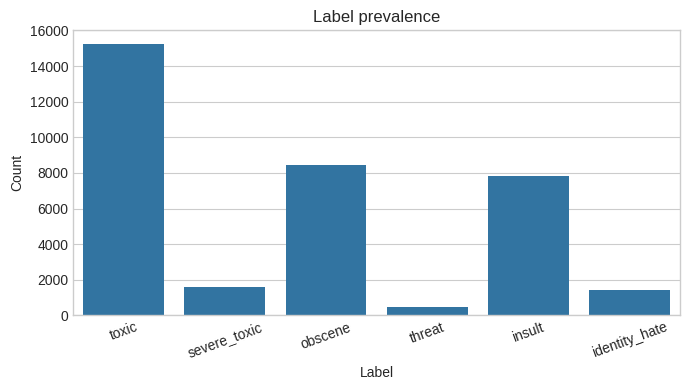

In [ ]:
counts = df[LABELS].sum().astype(int)
rates  = (counts / len(df)).round(4)

print("Label prevalence (count | rate):")
for lab in LABELS:
    print(f"{lab:14s} {int(counts[lab]):6d} | {rates[lab]:.4f}")

plt.figure(figsize=(7,4))
sns.barplot(x=LABELS, y=[counts[l] for l in LABELS])
plt.ylabel("Count"); plt.xlabel("Label"); plt.title("Label prevalence")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## Label Co-occurrence (which toxicities happen together?)
**What this code does:**  
- Builds a 6×6 co-occurrence **rate** matrix and plots a heatmap.  
**Why:** Helps interpret errors and supports the multi-label formulation.

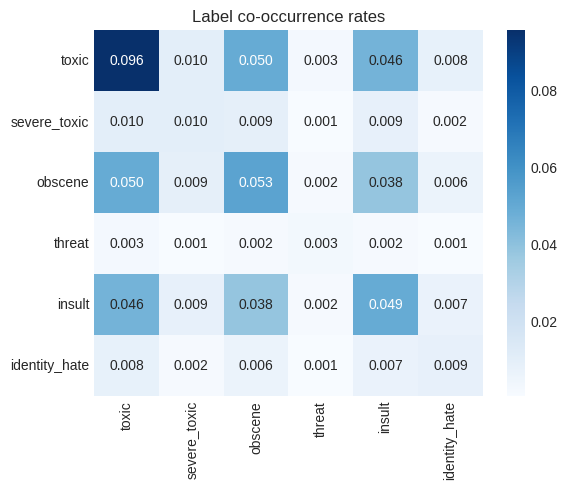

In [ ]:
Y = df[LABELS].values
co_counts = (Y.T @ Y)  # co-occurrence counts
co_rates = co_counts / len(df)

plt.figure(figsize=(6,5))
sns.heatmap(pd.DataFrame(co_rates, index=LABELS, columns=LABELS),
            annot=True, fmt=".3f", cmap="Blues")
plt.title("Label co-occurrence rates")
plt.tight_layout()

plt.show()

## Train / Validation / Test Split (reproducible)
**What this code does:**  
- Creates an **80/10/10** split with a fixed seed.  
- Uses a simple stratification proxy (number of positive labels per row) so splits are comparable.  
- Prints sizes and per-split prevalence to verify no major drift.

In [ ]:
def stratified_split_by_labelcount(frame, label_cols, train=0.8, val=0.1, test=0.1, seed=42):
    assert abs(train + val + test - 1.0) < 1e-6, "Splits must sum to 1."
    k = frame[label_cols].sum(axis=1)  # number of positive labels per row
    idx_train, idx_val, idx_test = [], [], []
    rng = np.random.RandomState(seed)

    for cnt in sorted(k.unique()):
        grp_idx = frame[k == cnt].index.values
        perm = rng.permutation(grp_idx)
        n = len(perm)
        n_train = int(np.floor(n * train))
        n_val   = int(np.floor(n * val))
        # ensure all rows are used
        n_test  = n - n_train - n_val
        idx_train.extend(perm[:n_train])
        idx_val.extend(perm[n_train:n_train+n_val])
        idx_test.extend(perm[n_train+n_val:])

    train_df = frame.loc[idx_train].sample(frac=1.0, random_state=seed).reset_index(drop=True)
    val_df   = frame.loc[idx_val].sample(frac=1.0, random_state=seed).reset_index(drop=True)
    test_df  = frame.loc[idx_test].sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split_by_labelcount(df, LABELS, 0.8, 0.1, 0.1, seed=SEED)

print(f"Split sizes → Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

def prevalence(frame):
    return (frame[LABELS].sum() / len(frame)).round(4).to_dict()

print("Overall prev.:", prevalence(df))
print("Train   prev.:", prevalence(train_df))
print("Val     prev.:", prevalence(val_df))
print("Test    prev.:", prevalence(test_df))

Split sizes → Train: 127,428 | Val: 15,926 | Test: 15,934
Overall prev.: {'toxic': 0.0957, 'severe_toxic': 0.01, 'obscene': 0.0529, 'threat': 0.003, 'insult': 0.0493, 'identity_hate': 0.0088}
Train   prev.: {'toxic': 0.0956, 'severe_toxic': 0.0101, 'obscene': 0.0527, 'threat': 0.0031, 'insult': 0.0494, 'identity_hate': 0.0086}
Val     prev.: {'toxic': 0.096, 'severe_toxic': 0.0089, 'obscene': 0.0533, 'threat': 0.0027, 'insult': 0.0492, 'identity_hate': 0.0091}
Test    prev.: {'toxic': 0.0961, 'severe_toxic': 0.0099, 'obscene': 0.0538, 'threat': 0.0023, 'insult': 0.0484, 'identity_hate': 0.0099}


## EDA takeaways → modelling decisions
- **Cleaning:** minimal (we kept toxic tokens), only removed formatting noise.  
- **Lengths:** most comments are short → we’ll start with `max_length=128` when we move to models.  
- **Imbalance:** strong skew across labels → we’ll report **micro-F1 & macro-F1**, include **per-label PR-AUC**, and later tune **per-label thresholds**.  
- **Reproducibility:** fixed seed and saved splits ensure fair comparison across all models.

## DistilBERT — Setup & Datasets (multi-label)

**What this does:**  
- Loads a DistilBERT checkpoint and tokenizer.  
- Wraps our `train_df`, `val_df`, `test_df` into small PyTorch datasets that return `input_ids`, `attention_mask`, and **6-dim float labels**.  
- Keeps things CPU-friendly (small batch, max_length=128).  

**Why:** The model outputs **6 logits** (one per label). We apply **sigmoid** later for probabilities and use **binary cross-entropy** during training (handled by the model when `problem_type='multi_label_classification'`).  

In [ ]:
import numpy as np, torch, random
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

# Assumes earlier EDA created: df, TEXT_COL, LABELS, train_df, val_df, test_df
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

MODEL_NAME = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

class ToxicDataset(Dataset):
    """Simple dataset for HF Trainer: returns input_ids, attention_mask, labels (float)."""
    def __init__(self, frame, text_col, label_cols, tokenizer, max_length=128):
        self.texts = frame[text_col].astype(str).tolist()
        self.labels = frame[label_cols].astype(int).values  # shape [n, 6]
        self.tok = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, padding=False, max_length=self.max_length)
        item = {k: torch.tensor(v) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.float32)  # float for BCEWithLogits
        return item

# Build datasets
train_ds = ToxicDataset(train_df, TEXT_COL, LABELS, tok, max_length=128)
val_ds   = ToxicDataset(val_df,   TEXT_COL, LABELS, tok, max_length=128)
test_ds  = ToxicDataset(test_df,  TEXT_COL, LABELS, tok, max_length=128)
print(f"Datasets → train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

# Model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABELS),
    problem_type="multi_label_classification"  # uses BCEWithLogits under the hood
).to(device)

# Collator pads to the longest sequence in a batch (efficient)
data_collator = DataCollatorWithPadding(tok, pad_to_multiple_of=8)

## Train DistilBERT (simple, CPU-friendly)

**What this does:**  
- Defines **TrainingArguments** with safe defaults (no fancy callbacks).  
- Trains for a small number of epochs (2 by default).  
- We’ll evaluate and tune thresholds **after** training.  

**Why:** Keep training stable and reproducible before adding extra complexity.  

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="./out_distilbert",
    learning_rate=2e-5,                 # good default for fine-tuning
    per_device_train_batch_size=8,      # small batch for CPU
    per_device_eval_batch_size=16,
    num_train_epochs=2,                 # try 3 later if time allows
    weight_decay=0.01,
    warmup_ratio=0.1,
    max_grad_norm=1.0,
    seed=SEED,
    report_to=[],                       # no external logging
    # NOTE: we avoid in-loop eval callbacks to keep compatibility with older transformers
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,                # we call predict/evaluate after training
    tokenizer=tok,
    data_collator=data_collator,
)

print(">>> Training starts")
trainer.train()
print(">>> Training finished")

## Validation — get probabilities & tune **per-label thresholds**

**What this does:**  
- Gets **validation probabilities** via `sigmoid(logits)`.  
- For each label, scans a small threshold grid (0.05 → 0.95) and picks the value that **maximises F1** for that label.  
- Prints: Validation **Micro-F1**, **Macro-F1**, **Mean PR-AUC**, and the chosen threshold per label.  

**Why:** A single 0.5 threshold is rarely optimal on imbalanced labels; **per-label thresholds** improve Macro-F1 and rare-label recall.  

In [ ]:
from sklearn.metrics import f1_score, average_precision_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 1) Validation probabilities/labels
val_logits = trainer.predict(val_ds).predictions
val_probs  = sigmoid(val_logits)
val_y      = val_df[LABELS].values.astype(int)

# 2) Threshold tuning per label (small grid for speed)
def tune_thresholds_by_f1(y_true, y_prob, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)  # 0.05, 0.10, ..., 0.95
    K = y_true.shape[1]
    thr = np.zeros(K, dtype=float)
    f1s = np.zeros(K, dtype=float)
    for k in range(K):
        best_f1, best_t = 0.0, 0.5
        col_true, col_prob = y_true[:, k], y_prob[:, k]
        for t in grid:
            pred = (col_prob >= t).astype(int)
            f1 = f1_score(col_true, pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thr[k], f1s[k] = best_t, best_f1
    return thr, f1s

thr, val_f1_per_label = tune_thresholds_by_f1(val_y, val_probs)

# 3) Validation summary with tuned thresholds
val_pred_tuned = (val_probs >= thr).astype(int)
val_micro = f1_score(val_y, val_pred_tuned, average="micro", zero_division=0)
val_macro = f1_score(val_y, val_pred_tuned, average="macro", zero_division=0)
val_ap    = [average_precision_score(val_y[:,i], val_probs[:,i]) for i in range(len(LABELS))]

print("=== Validation (tuned thresholds) ===")
print(f"Micro-F1: {val_micro:.3f}  |  Macro-F1: {val_macro:.3f}  |  Mean PR-AUC: {np.mean(val_ap):.3f}")
print("\nPer-label thresholds & F1 on Val:")
for lab, t, f1 in zip(LABELS, thr, val_f1_per_label):
    print(f"  {lab:14s} t*={t:.3f}  F1={f1:.3f}")

NameError: name 'trainer' is not defined

## Baseline — TF-IDF + LinearSVC (Multi-label: 6 heads)

**Goal:** Build a simple multi-label SVM baseline using TF-IDF text features with a One-vs-Rest LinearSVC classifier.  
Each comment is evaluated across six independent toxicity labels — `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`.  
The model predicts a separate binary outcome for each label (multi-label classification).  
Thresholds are tuned per label on the validation set to maximise F1, and evaluation is reported on the test set using Micro-F1, Macro-F1, per-label F1, and PR-AUC.


In [ ]:


import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, average_precision_score

# ---------------- Text arrays ----------------
X_train_txt = train_df[TEXT_COL].astype(str).values
X_val_txt   = val_df[TEXT_COL].astype(str).values
X_test_txt  = test_df[TEXT_COL].astype(str).values

# ---------------- 6-label targets (multi-label) ----------------
Y_train = train_df[LABELS].astype(int).values   # s
Y_val   = val_df[LABELS].astype(int).values     #
Y_test  = test_df[LABELS].astype(int).values    #

# --
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=100_000,      #
    sublinear_tf=True,         #
    lowercase=False            #
)
X_train = tfidf.fit_transform(X_train_txt)
X_val   = tfidf.transform(X_val_txt)
X_test  = tfidf.transform(X_test_txt)

print("TF-IDF shapes  ->  Train:", X_train.shape, " | Val:", X_val.shape, " | Test:", X_test.shape)

# ---------------- Trai
svc_ovr = OneVsRestClassifier(
    LinearSVC(class_weight='balanced', random_state=42)
)
svc_ovr.fit(X_train, Y_train)

# ---------------- Validation sco
val_scores = svc_ovr.decision_function(X_val)   # ma
if val_scores.ndim == 1:
    val_scores = val_scores[:, None]

def tune_thresholds_by_f1(y_true, scores, n_grid=101, low_q=2, high_q=98):
    """
    For each label k, search a threshold t on the decision scores that maximizes F1.
    We restrict the search between percentiles [low_q, high_q] to avoid extreme outliers.
    """
    K = y_true.shape[1]
    thr = np.zeros(K, dtype=float)
    best = np.zeros(K, dtype=float)
    for k in range(K):
        s = scores[:, k]
        lo, hi = np.percentile(s, low_q), np.percentile(s, high_q)
        grid = np.linspace(lo, hi, n_grid)
        best_f1, best_t = -1.0, 0.0
        for t in grid:
            pred = (s >= t).astype(int)
            f1 = f1_score(y_true[:, k], pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thr[k], best[k] = best_t, best_f1
    return thr, best

svc_thr, val_f1_per_label = tune_thresholds_by_f1(Y_val, val_scores)

print("\nPer-label thresholds tuned on Validation:")
for lab, t, f1 in zip(LABELS, svc_thr, val_f1_per_label):
    print(f"  {lab:14s}  t* = {t:.3f}   F1_val = {f1:.3f}")

# ---------------- Test-time prediction + metrics (Micro-F1, Macro-F1, per-label F1, Mean PR-AUC) ----------------
test_scores = svc_ovr.decision_function(X_test)
if test_scores.ndim == 1:
    test_scores = test_scores[:, None]

test_pred = (test_scores >= svc_thr).astype(int)



per_label_f1 = [f1_score(Y_test[:, i], test_pred[:, i], zero_division=0) for i in range(len(LABELS))]
per_label_ap = [average_precision_score(Y_test[:, i], test_scores[:, i]) for i in range(len(LABELS))]
mean_pr_auc  = float(np.mean(per_label_ap))

##print("\n=== TF-IDF + LinearSVC (Multi-label) — Test ===")
##print(f"Micro-F1: {micro_f1:.3f} | Macro-F1: {macro_f1:.3f} | Mean PR-AUC: {mean_pr_auc:.3f}")

results_df = pd.DataFrame({
    "Label":  LABELS,
    "F1":     np.round(per_label_f1, 3),
    "PR-AUC": np.round(per_label_ap, 3),
})
print("\nPer-label scores:")
display(results_df)
# ===================================================================================================


TF-IDF shapes  ->  Train: (127428, 100000)  | Val: (15926, 100000)  | Test: (15934, 100000)

Per-label thresholds tuned on Validation:
  toxic           t* = 0.220   F1_val = 0.761
  severe_toxic    t* = -0.141   F1_val = 0.407
  obscene         t* = 0.268   F1_val = 0.790
  threat          t* = -0.803   F1_val = 0.193
  insult          t* = 0.173   F1_val = 0.680
  identity_hate   t* = -0.291   F1_val = 0.404

Per-label scores:


,Label,F1,PR-AUC
0,toxic,0.761,0.846
1,severe_toxic,0.438,0.341
2,obscene,0.795,0.866
3,threat,0.186,0.381
4,insult,0.696,0.743
5,identity_hate,0.412,0.438


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Text → TF-IDF features

**What:** Unigram+bigram TF-IDF (log-scaled TF), large but capped vocab.  
**Important:** Fit on **Train only**, then transform Test.

### Train LinearSVC (balanced)

**What:** Linear SVM with class weighting to handle imbalance.  
**Output:** We’ll use both hard predictions (`predict`) and **decision margins** (`decision_function`) for metrics.

### TF-IDF + LinearSVC — Validation threshold tuning (to mirror DistilBERT)

**What this does:**  
- Gets **Validation decision margins** (`decision_function`) for each label.  
- Finds a **per-label threshold** that maximises **F1** on Validation (small, fast grid).  
- Prints the chosen thresholds (we’ll reuse them on Test).

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# 1) Validation scores (margins)
val_scores = svc_ovr.decision_function(X_val)   # shape [n_val, n_labels]
if val_scores.ndim == 1: val_scores = val_scores[:, None]
Y_val = Y_val  # already defined from your TF-IDF step

# 2) Tune per-label thresholds on Validation
def tune_thresholds_by_f1(y_true, scores, n_grid=101, low_q=2, high_q=98):
    K = y_true.shape[1]
    thr = np.zeros(K, dtype=float)
    f1s = np.zeros(K, dtype=float)
    for k in range(K):
        s = scores[:, k]
        lo, hi = np.percentile(s, low_q), np.percentile(s, high_q)
        grid = np.linspace(lo, hi, n_grid)
        best_f1, best_t = -1.0, 0.0
        for t in grid:
            pred = (s >= t).astype(int)
            f1 = f1_score(y_true[:, k], pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thr[k], f1s[k] = best_t, best_f1
    return thr, f1s

svc_thr, val_f1_per_label = tune_thresholds_by_f1(Y_val, val_scores)

print("Per-label thresholds chosen on Validation:")
for lab, t, f1 in zip(LABELS, svc_thr, val_f1_per_label):
    print(f"  {lab:14s} t* = {t:.3f}   F1@Val = {f1:.3f}")

Per-label thresholds chosen on Validation:
  toxic          t* = 0.220   F1@Val = 0.761
  severe_toxic   t* = -0.141   F1@Val = 0.407
  obscene        t* = 0.268   F1@Val = 0.790
  threat         t* = -0.803   F1@Val = 0.193
  insult         t* = 0.173   F1@Val = 0.680
  identity_hate  t* = -0.291   F1@Val = 0.404


### TF-IDF + LinearSVC — Test evaluation (with tuned thresholds)

**What this does:**  
- Applies the **Validation-tuned thresholds** to **Test** margins.  
- Reports **Micro-F1**, **Macro-F1**, per-label **F1**, and per-label **PR-AUC** (+ **Mean PR-AUC**) — consistent with the DistilBERT section.

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, average_precision_score

# 1) Test scores (margins)
test_scores = svc_ovr.decision_function(X_test)
if test_scores.ndim == 1: test_scores = test_scores[:, None]

# 2) Apply tuned thresholds
test_pred = (test_scores >= svc_thr).astype(int)

# 3) Metrics (mirror DistilBERT format)
micro_f1 = f1_score(Y_test, test_pred, average="micro", zero_division=0)
macro_f1 = f1_score(Y_test, test_pred, average="macro", zero_division=0)

per_label_f1 = [f1_score(Y_test[:, i], test_pred[:, i], zero_division=0) for i in range(len(LABELS))]
per_label_ap = [average_precision_score(Y_test[:, i], test_scores[:, i]) for i in range(len(LABELS))]
mean_pr_auc = float(np.mean(per_label_ap))

print("=== TF-IDF + LinearSVC — Test (tuned thresholds) ===")
print(f"Micro-F1: {micro_f1:.3f} | Macro-F1: {macro_f1:.3f} | Mean PR-AUC: {mean_pr_auc:.3f}\n")

# 1) Test scores (margins)
test_scores = svc_ovr.decision_function(X_test)
if test_scores.ndim == 1:
    test_scores = test_scores[:, None]

# 2) Apply tuned thresholds
test_pred = (test_scores >= svc_thr).astype(int)

# 3) Metrics (mirror DistilBERT format)
from sklearn.metrics import f1_score, average_precision_score
import numpy as np, pandas as pd

per_label_f1 = [f1_score(Y_test[:, i], test_pred[:, i], zero_division=0) for i in range(len(LABELS))]
per_label_ap = [average_precision_score(Y_test[:, i], test_scores[:, i]) for i in range(len(LABELS))]
mean_pr_auc  = float(np.mean(per_label_ap))

micro_f1 = f1_score(Y_test, test_pred, average="micro", zero_division=0)
macro_f1 = f1_score(Y_test, test_pred, average="macro", zero_division=0)

print("=== TF-IDF + LinearSVC — Test (tuned thresholds) ===")
print(f"Micro-F1: {micro_f1:.3f} | Macro-F1: {macro_f1:.3f} | Mean PR-AUC: {mean_pr_auc:.3f}\n")

summary = pd.DataFrame({
    "Label": LABELS,
    "F1":    np.round(per_label_f1, 3),
    "PR-AUC":np.round(per_label_ap, 3),
})
display(summary)

=== TF-IDF + LinearSVC — Test (tuned thresholds) ===
Micro-F1: 0.685 | Macro-F1: 0.548 | Mean PR-AUC: 0.603

=== TF-IDF + LinearSVC — Test (tuned thresholds) ===
Micro-F1: 0.685 | Macro-F1: 0.548 | Mean PR-AUC: 0.603



,Label,F1,PR-AUC
0,toxic,0.761,0.846
1,severe_toxic,0.438,0.341
2,obscene,0.795,0.866
3,threat,0.186,0.381
4,insult,0.696,0.743
5,identity_hate,0.412,0.438


#BiLSTM
**Embedding → BiLSTM → Pooling → Dense(6, sigmoid)**

**Goal:**
* Build a BiLSTM model that captures word order to predict six
toxicity labels : toxic, severe_toxic, obscene, threat, insult, identity_hate.

* Predict probabilities per label with thresholds tuned on validation.

* Evaluate using Micro-F1, Macro-F1, per-label F1, and PR-AUC.

**What this does:**

* Converts text to padded sequences.

* Processes sequences with a bidirectional LSTM.

* Pools the output and applies a dense layer with sigmoid activation for multi-label prediction.

**Why:**

* Captures sequential context in comments.

* Handles multi-label classification with imbalanced data.

###BiLSTM - Tokenizer & Sequences

**What this does:**
* Converts text comments into integer sequences using a tokenizer.
* Pads sequences to a fixed length (max_length=128) so all inputs are uniform.
* Prepares multi-label targets for the six toxicity labels.

In [ ]:
# TEXT TOKENIZATION & PADDING
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

MAX_WORDS = 20000     # Vocabulary size (keep top 20k words)
MAX_LEN = 128         # Based on your earlier EDA

# Tokenizer (fit on TRAIN only to avoid leakage)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df[TEXT_COL])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df[TEXT_COL])
X_val   = tokenizer.texts_to_sequences(val_df[TEXT_COL])
X_test  = tokenizer.texts_to_sequences(test_df[TEXT_COL])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding="post", truncating="post")
X_val   = pad_sequences(X_val,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test  = pad_sequences(X_test,  maxlen=MAX_LEN, padding="post", truncating="post")

# Label matrices
Y_train = train_df[LABELS].values
Y_val   = val_df[LABELS].values
Y_test  = test_df[LABELS].values

print("Tokenized & padded shapes →",
      f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Tokenized & padded shapes → Train: (127428, 128), Val: (15926, 128), Test: (15934, 128)


###BiLSTM - Model Architecture

**What this does:**
* Maps tokens to embeddings.
* Processes them with a bidirectional LSTM to capture context.
* Applies global max pooling to condense the sequence output.
* Outputs 6 independent probabilities with sigmoid activation for multi-label prediction.

In [ ]:
# BUILD BiLSTM MODEL

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

EMBED_DIM = 100       # Embedding dimension for each word vector

# Build model
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN), # Embedding layer
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(6, activation="sigmoid")  # 6 independent outputs for multi-label
])

# Compile model
# used 'binary_crossentropy' since each label is independent (sigmoid output)
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TRAIN BiLSTM MODEL

EPOCHS = 50
BATCH_SIZE = 128

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6980 - loss: 0.1394 - val_accuracy: 0.9946 - val_loss: 0.0507
Epoch 2/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9708 - loss: 0.0496 - val_accuracy: 0.9946 - val_loss: 0.0492
Epoch 3/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9789 - loss: 0.0441 - val_accuracy: 0.9946 - val_loss: 0.0502
Epoch 4/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9515 - loss: 0.0396 - val_accuracy: 0.9946 - val_loss: 0.0506
Epoch 5/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9573 - loss: 0.0355 - val_accuracy: 0.9946 - val_loss: 0.0528
Epoch 6/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9194 - loss: 0.0320 - val_accuracy: 0.9945 - val_loss: 0.0569
Epoch 7/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8959 - loss: 0.0290 - val_accuracy: 0.9941 - val_loss: 0.0649
Epoch 8/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7948 - loss: 0.0263 - 

###BiLSTM - Test Evaluation

**What this does:**
* Applies the per-label thresholds tuned on the validation set to test predictions.
* Reports Micro-F1, Macro-F1, per-label F1, and PR-AUC (mean included).
* Report model size and inference time per 1,000 comments for efficiency comparison.

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import time
import tensorflow as tf

# Predict probabilities
y_val_prob = model.predict(X_val)
y_test_prob = model.predict(X_test)

# Tune thresholds per label on validation
thresholds = []
for i in range(len(LABELS)):
    best_thresh, best_f1 = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.05):
        f1 = f1_score(Y_val[:, i], (y_val_prob[:, i] >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_thresh = f1, t
    thresholds.append(best_thresh)

print("Optimal thresholds per label:", dict(zip(LABELS, thresholds)))

# Apply thresholds to test set
y_test_pred = np.zeros_like(y_test_prob, dtype=int)
for i, t in enumerate(thresholds):
    y_test_pred[:, i] = (y_test_prob[:, i] >= t).astype(int)

# Micro-F1 & Macro-F1
micro_f1 = f1_score(Y_test, y_test_pred, average='micro')
macro_f1 = f1_score(Y_test, y_test_pred, average='macro')
print(f"Micro-F1: {micro_f1:.4f} | Macro-F1: {macro_f1:.4f}")

# Per-label F1
print("\nPer-label classification report:")
print(classification_report(Y_test, y_test_pred, target_names=LABELS, zero_division=0))

# PR-AUC per label
pr_auc = {label: roc_auc_score(Y_test[:, i], y_test_prob[:, i]) for i, label in enumerate(LABELS)}
print("\nPer-label PR-AUC:", pr_auc)
print("Mean PR-AUC:", np.mean(list(pr_auc.values())))

# Optional: Model size and inference time per 1,000 comments
model_size = model.count_params()
print(f"\nModel size (parameters): {model_size:,}")

start_time = time.time()
_ = model.predict(np.repeat(X_test[:1000], 1, axis=0))
inference_time = time.time() - start_time
print(f"Inference time per 1,000 comments: {inference_time:.2f} seconds")

498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Optimal thresholds per label: {'toxic': np.float64(0.45000000000000007), 'severe_toxic': np.float64(0.30000000000000004), 'obscene': np.float64(0.5000000000000001), 'threat': np.float64(0.8500000000000002), 'insult': np.float64(0.1), 'identity_hate': np.float64(0.15000000000000002)}
Micro-F1: 0.6897 | Macro-F1: 0.5711

Per-label classification report:
               precision    recall  f1-score   support

        toxic       0.73      0.73      0.73      1531
 severe_toxic       0.36      0.46      0.40       158
      obscene       0.80      0.73      0.76       858
       threat       0.52      0.38      0.44        37
       insult       0.65      0.71      0.68       772
identity_hate       0.40      0.45      0.42       158

    micro avg       0.69      0.69      0.69      3514
    macro avg       0.57      0.57      0.57      3514
 weighted avg       0.69      0.69      0.69      3514
  samples av